# CAM Application on CNN-based model

In this notebook, CAM (Class Activation Mapping) techniques are applied, in particular the ScoreCAM algorithm, to provide visual explainability to the proposed model.
For the analysis, 10 images from each class were selected randomly.

## 1. Import main dependencies and definition of recurring functions

In [1]:
import os 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import numpy as np
import cv2

import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model, Model

In [2]:
def ScoreCam(model, img_array, layer_name, max_N=-1):

    cls = np.argmax(model(img_array))
    base_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    act_map_array = base_model(img_array)
    act_map_array = np.asarray(act_map_array)
    
    # extract effective maps
    if max_N != -1:
        act_map_std_list = [np.std(act_map_array[0,:,:,k]) for k in range(act_map_array.shape[3])]
        unsorted_max_indices = np.argpartition(-np.array(act_map_std_list), max_N)[:max_N]
        max_N_indices = unsorted_max_indices[np.argsort(-np.array(act_map_std_list)[unsorted_max_indices])]
        act_map_array = act_map_array[:,:,:,max_N_indices]

    input_shape = model.layers[0].output_shape[0][1:]  # get input shape
    # 1. upsample to original input size
    act_map_resized_list = [cv2.resize(act_map_array[0,:,:,k], input_shape[:2], interpolation=cv2.INTER_LINEAR) for k in range(act_map_array.shape[3])]
    # 2. normalize the raw activation value in each activation map into [0, 1]
    act_map_normalized_list = []
    for act_map_resized in act_map_resized_list:
        if np.max(act_map_resized) - np.min(act_map_resized) != 0:
            act_map_normalized = act_map_resized / (np.max(act_map_resized) - np.min(act_map_resized))
        else:
            act_map_normalized = act_map_resized
        act_map_normalized_list.append(act_map_normalized)
    # 3. project highlighted area in the activation map to original input space by multiplying the normalized activation map
    masked_input_list = []
    for act_map_normalized in act_map_normalized_list:
        masked_input = np.copy(img_array)
        for k in range(3):
            masked_input[0,:,:,k] *= act_map_normalized
        masked_input_list.append(masked_input)
    masked_input_array = np.concatenate(masked_input_list, axis=0)
    # 4. feed masked inputs into CNN model and softmax
    pred_from_masked_input_array = softmax(model.predict(masked_input_array))
    # 5. define weight as the score of target class
    weights = pred_from_masked_input_array[:,cls]
    # 6. get final class discriminative localization map as linear weighted combination of all activation maps
    cam = np.dot(act_map_array[0,:,:,:], weights)
    cam = np.maximum(0, cam)  # Passing through ReLU
    cam /= np.max(cam)  # scale 0 to 1.0
    
    return cam

def superimpose(original_img_path, cam, emphasize=False):
    
    img_bgr = cv2.imread(original_img_path)

    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, 0.5, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

def softmax(x):
    f = np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims = True)
    return f

def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def read_and_process_image(image_path):
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    H, W, _ = image.shape
    
    t_image = cv2.resize(image, (100, 100))
    t_image = np.expand_dims(t_image, axis=0)
    t_image = t_image.reshape(-1, 100, 100, 3)
    t_image = t_image.astype("float32")
    
    return t_image, W, H

def decode_prediction(index):
    if index == 0:
        return "CNV"
    elif index == 1:
        return "DME"
    elif index == 2:
        return "DRUSEN"
    elif index == 3:
        return "NORMAL"
    
def plot_scorecam(scorecams, original, model_name):
    
    plt.figure(figsize=(25, 8))
    i = 0
    
    for data, image_path in zip(scorecams, original):
        
        image = cv2.imread(image_path)
        comparison = cv2.hconcat([image, data[0]])
        
        predicted_class = data[1]
        true_class = image_path.split("/")[-2]
        filename = image_path.split("/")[-1].split(".")[0]
        filename = filename + "__TRUE_{}_PREDICTED_{}.png".format(true_class, predicted_class)
        save_path = os.path.join("ScoreCAM", model_name, true_class)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        save_path = os.path.join("ScoreCAM", model_name, true_class, filename)
        plt.imsave(save_path, comparison)
        
        ax = plt.subplot(4, 5, i+1)
        plt.imshow(comparison)
        plt.axis('off')
        plt.title("Predicted class : {}".format(predicted_class)) 
        i += 1

    plt.show()
    
def make_cam(model, input_array):
    
    output_array=[]
    
    for image in input_array:
        
        tensor, W, H = read_and_process_image(image)
        pred = model(tensor)
        idx = np.argmax(pred[0])
        predicted_class = decode_prediction(idx)
        scorecam = ScoreCam(model, tensor, "conv1d_2")
        scorecam = superimpose(image, scorecam)
        
        output_array.append((scorecam, predicted_class))
        
    return output_array

## 2. Loading model and test images

In [3]:
FCNNplus_model = load_model("saved_models/FCNNplus/")

In [4]:
NORMAL_path = "test_images/NORMAL"
CNV_path = "test_images/CNV"
DME_path = "test_images/DME"
DRUSEN_path = "test_images/DRUSEN"

NORMAL_images = [os.path.join(NORMAL_path, file) for file in os.listdir(NORMAL_path)]
DRUSEN_images = [os.path.join(DRUSEN_path, file) for file in os.listdir(DRUSEN_path)]
CNV_images = [os.path.join(CNV_path, file) for file in os.listdir(CNV_path)]
DME_images = [os.path.join(DME_path, file) for file in os.listdir(DME_path)]

In [5]:
print("[INFO] Processing NORMAL class")
scoreCAM_NORMAL = make_cam(FCNNplus_model, NORMAL_images)

print("[INFO] Processing CNV class")
scoreCAM_CNV = make_cam(FCNNplus_model, CNV_images)

print("[INFO] Processing DME class")
scoreCAM_DME = make_cam(FCNNplus_model, DME_images)

print("[INFO] Processing DRUSEN class")
scoreCAM_DRUSEN = make_cam(FCNNplus_model, DRUSEN_images)

[INFO] Processing NORMAL class
[INFO] Processing CNV class
[INFO] Processing DME class
[INFO] Processing DRUSEN class


## 3. ScoreCAM visualization

### 3.1 NORMAL class

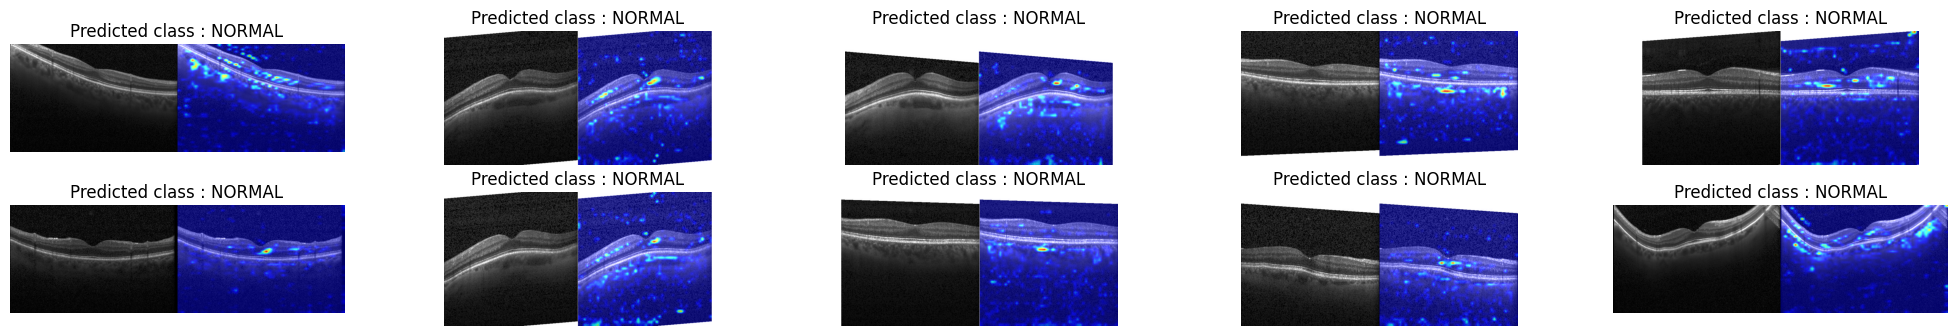

In [6]:
plot_scorecam(scoreCAM_NORMAL, NORMAL_images, "FCNNplus")

### 3.2 CNV class

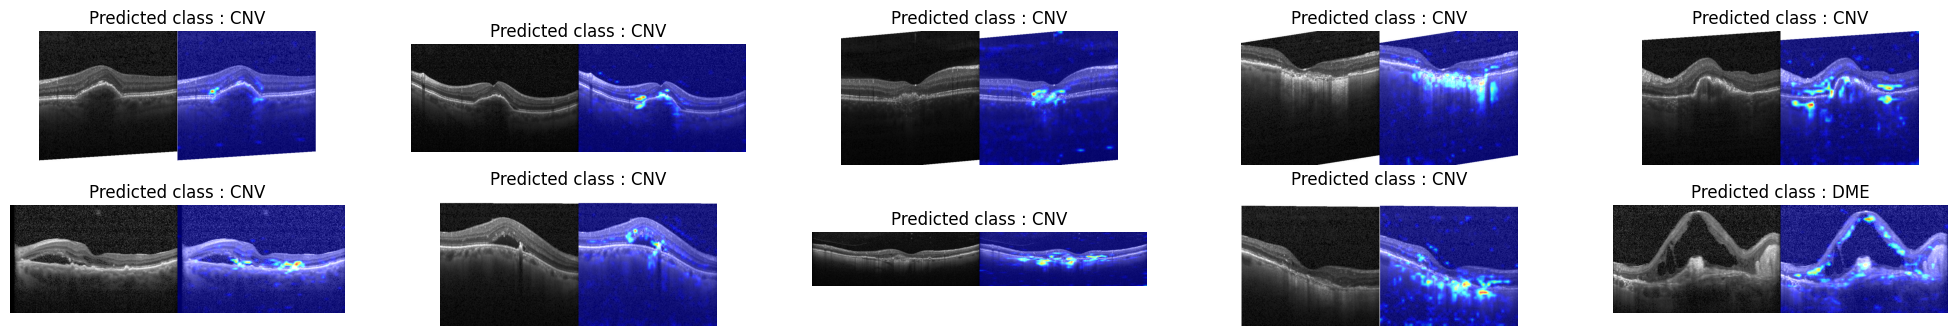

In [7]:
plot_scorecam(scoreCAM_CNV, CNV_images, "FCNNplus")

### 3.3. DME class

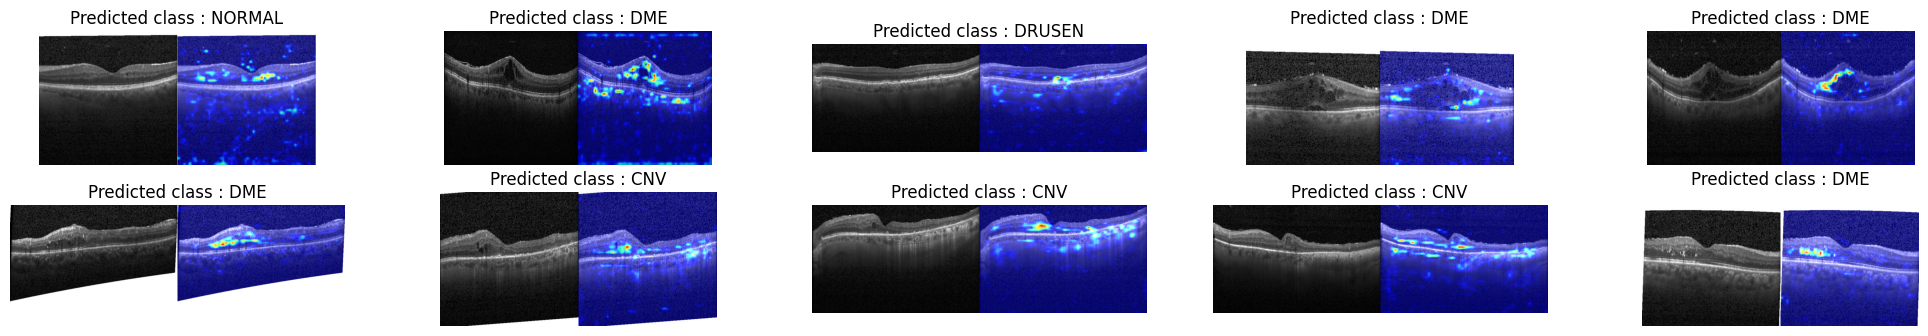

In [8]:
plot_scorecam(scoreCAM_DME, DME_images, "FCNNplus")

### 3.4 DRUSEN class

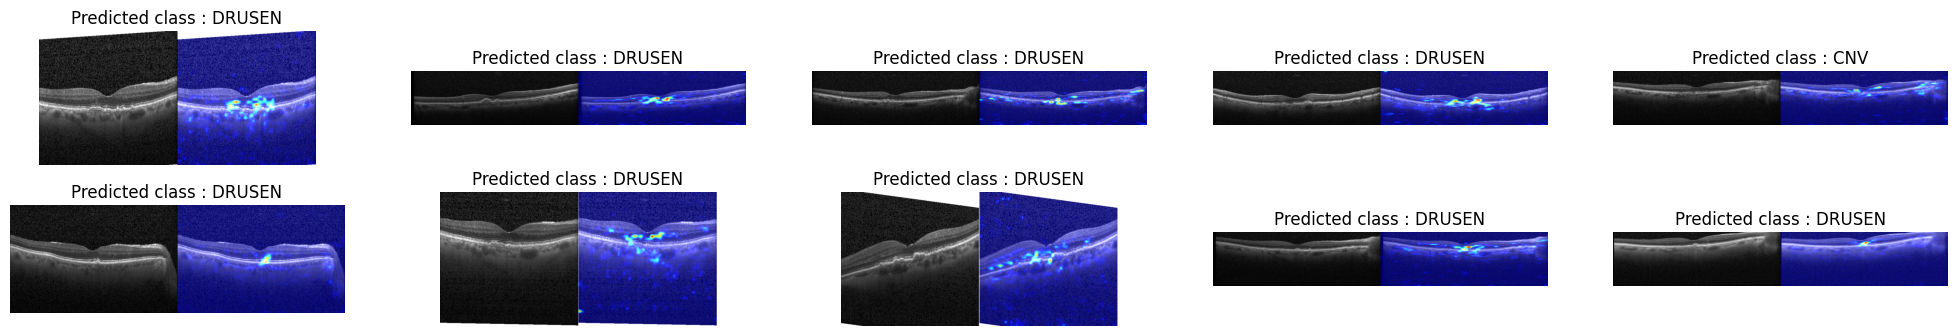

In [9]:
plot_scorecam(scoreCAM_DRUSEN, DRUSEN_images, "FCNNplus")